<a href="https://colab.research.google.com/github/sodiq-sulaimon/Receipts_Count_Prediction/blob/main/receipt_prediction/Receipt_prediction_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [ ]:
! wget https://fetch-hiring.s3.amazonaws.com/machine-learning-engineer/receipt-count-prediction/data_daily.csv

--2023-11-20 21:04:25--  https://fetch-hiring.s3.amazonaws.com/machine-learning-engineer/receipt-count-prediction/data_daily.csv
Resolving fetch-hiring.s3.amazonaws.com (fetch-hiring.s3.amazonaws.com)... 3.5.25.107, 52.216.244.164, 3.5.28.30, ...
Connecting to fetch-hiring.s3.amazonaws.com (fetch-hiring.s3.amazonaws.com)|3.5.25.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6981 (6.8K) [text/csv]
Saving to: ‘data_daily.csv’

data_daily.csv      100%[===================>]   6.82K  --.-KB/s    in 0s      

2023-11-20 21:04:26 (266 MB/s) - ‘data_daily.csv’ saved [6981/6981]



In [ ]:
# Read the dataset
df = pd.read_csv('data_daily.csv')

In [ ]:
df.head()

,# Date,Receipt_Count
0,2021-01-01,7564766
1,2021-01-02,7455524
2,2021-01-03,7095414
3,2021-01-04,7666163
4,2021-01-05,7771289


In [ ]:
df.columns

Index(['# Date', 'Receipt_Count'], dtype='object')

In [ ]:
# Rename the columns
df = df.rename(columns= {'# Date' : 'date', 'Receipt_Count': 'receipt_count'})

In [ ]:
df.columns

Index(['date', 'receipt_count'], dtype='object')

In [ ]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df.head()

,date,receipt_count
0,2021-01-01,7564766
1,2021-01-02,7455524
2,2021-01-03,7095414
3,2021-01-04,7666163
4,2021-01-05,7771289


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           365 non-null    datetime64[ns]
 1   receipt_count  365 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB


In [ ]:
# Sort the DataFrame by date
df.sort_values('date', inplace=True)

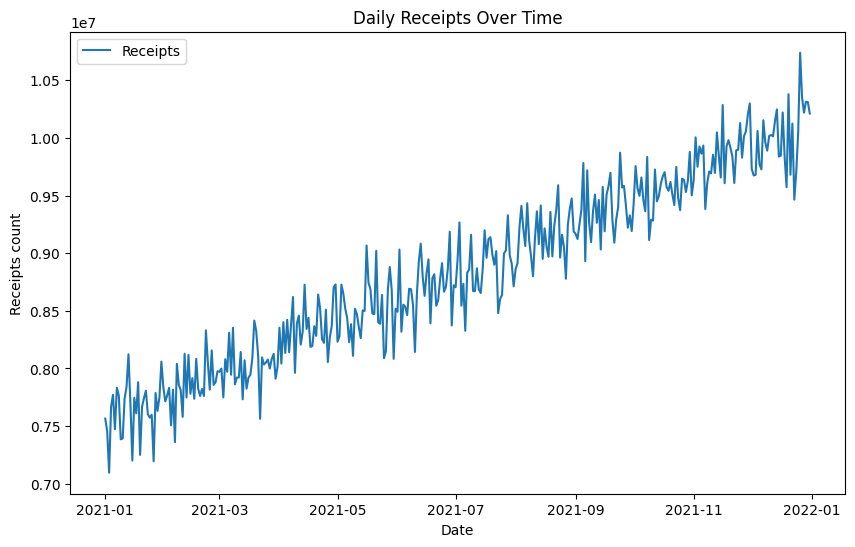

In [ ]:
# Visualize the time series
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['receipt_count'], label='Receipts')
plt.title('Daily Receipts Over Time')
plt.xlabel('Date')
plt.ylabel('Receipts count')
plt.legend()
plt.show()

In [ ]:
# Feature engineering
# Extract day of the week and month as additional features
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['day_of_month'] = df['date'].dt.day


In [ ]:
df.head()

,date,receipt_count,day_of_week,month,day_of_month
0,2021-01-01,7564766,4,1,1
1,2021-01-02,7455524,5,1,2
2,2021-01-03,7095414,6,1,3
3,2021-01-04,7666163,0,1,4
4,2021-01-05,7771289,1,1,5


Week starts at Monday. 0 = Monday, 1 = Tuesday, and so on

In [ ]:
df['receipt_count'].max()

10738865

In [ ]:
df['receipt_count'].min()

7095414

In [ ]:
1e7

10000000.0

In [ ]:
# Divide the receipt count column by 1e7 to scale down the numbers
df['receipt_count'] = df['receipt_count'] / 1e7

In [ ]:
df.head()


,date,receipt_count,day_of_week,month,day_of_month
0,2021-01-01,0.756477,4,1,1
1,2021-01-02,0.745552,5,1,2
2,2021-01-03,0.709541,6,1,3
3,2021-01-04,0.766616,0,1,4
4,2021-01-05,0.777129,1,1,5


In [ ]:
# # Train-test split (80% training, 20% testing)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]


In [ ]:
# SARIMA model
model = SARIMAX(train['receipt_count'],order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
result = model.fit(disp=False)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Make predictions for the test set
predictions = result.get_forecast(steps=len(test))
predicted_values = predictions.predicted_mean


In [ ]:
# Evaluate the model
mae = mean_absolute_error(test['receipt_count'], predicted_values)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 0.018386357189916658


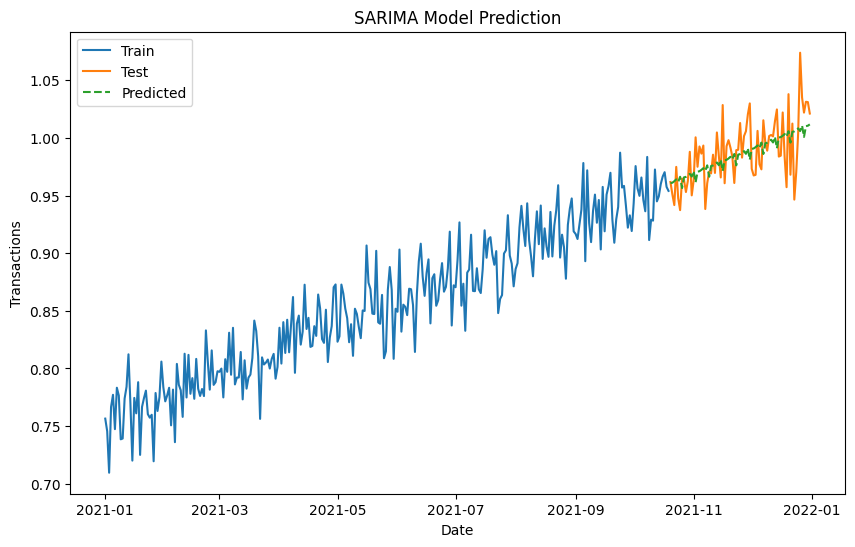

In [ ]:
# Visualize predictions
plt.figure(figsize=(10, 6))
plt.plot(train['date'], train['receipt_count'], label='Train')
plt.plot(test['date'], test['receipt_count'], label='Test')
plt.plot(test['date'], predicted_values, label='Predicted', linestyle='--')
plt.title('SARIMA Model Prediction')
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.legend()
plt.show()

In [ ]:
# Generate dates for the next year
next_year_dates = pd.date_range(df['date'].max() + pd.Timedelta(days=1), periods=365, freq='D')


In [ ]:
# Make predictions for the next year
forecast = result.get_forecast(steps=len(next_year_dates))
forecast_values = forecast.predicted_mean

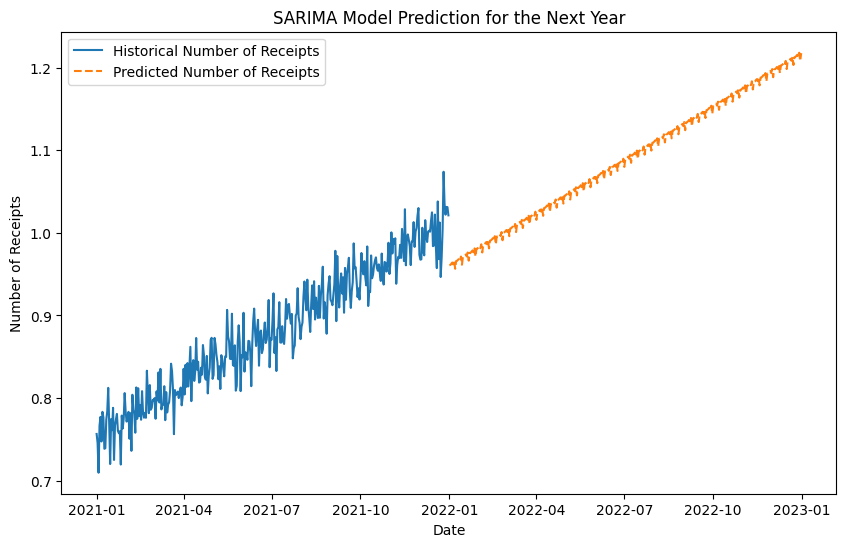

In [ ]:
# Visualize predictions for the next year
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['receipt_count'], label='Historical Number of Receipts')
plt.plot(next_year_dates, forecast_values, label='Predicted Number of Receipts', linestyle='--')
plt.title('SARIMA Model Prediction for the Next Year')
plt.xlabel('Date')
plt.ylabel('Number of Receipts')
plt.legend()
plt.show()

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [ ]:
# Feature engineering: Extracting additional features
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_month'] = df['date'].dt.day
df['month'] = df['date'].dt.month

In [ ]:
df.head()

,date,receipt_count,day_of_week,month,day_of_month
0,2021-01-01,7564766,4,1,1
1,2021-01-02,7455524,5,1,2
2,2021-01-03,7095414,6,1,3
3,2021-01-04,7666163,0,1,4
4,2021-01-05,7771289,1,1,5


In [ ]:
# Train-test split
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

In [ ]:
# Features and target variable
features = ['day_of_week', 'day_of_month', 'month']
target = 'receipt_count'

In [ ]:
# Training set
X_train = train_data[features]
y_train = train_data[target] / 1e7

# Testing set
X_test = test_data[features]
y_test = test_data[target] /1e7

In [ ]:
# Model initialization and training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Prediction for the testing set
predictions = model.predict(X_test)

In [ ]:
# Model evaluation
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 0.03606246664383573


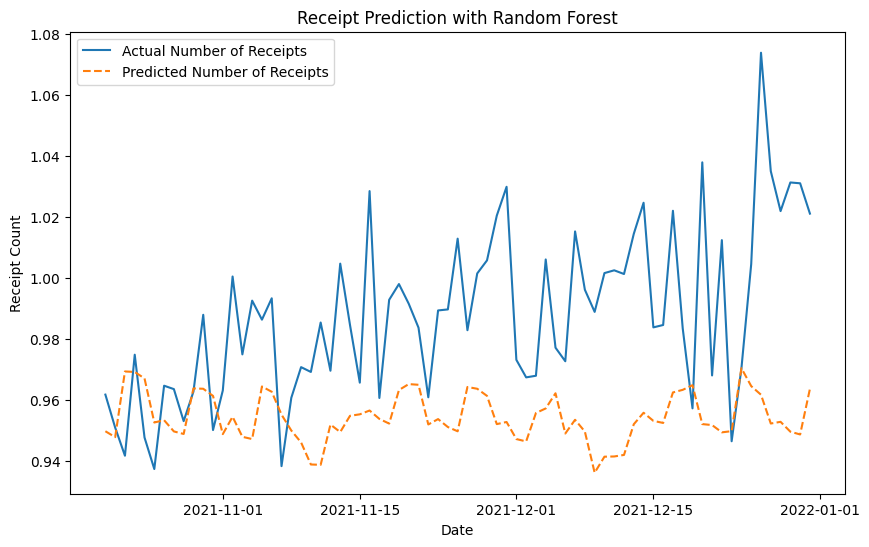

In [ ]:
# Visualization
plt.figure(figsize=(10, 6))
plt.plot(test_data['date'], y_test, label='Actual Number of Receipts')
plt.plot(test_data['date'], predictions, label='Predicted Number of Receipts', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Receipt Count')
plt.title('Receipt Prediction with Random Forest')
plt.legend()
plt.show()

In [ ]:
# Prediction for another year (adjust dates accordingly)
future_dates = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')
future_features = pd.DataFrame({
    'day_of_week': future_dates.dayofweek,
    'day_of_month': future_dates.day,
    'month': future_dates.month
})

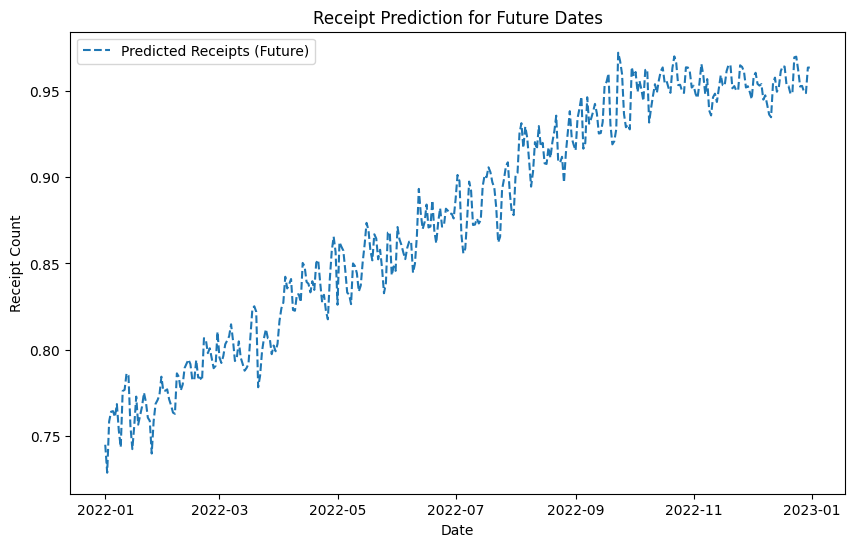

In [ ]:
# Make predictions for the future dates
future_predictions = model.predict(future_features)

# Visualization for future predictions
plt.figure(figsize=(10, 6))
plt.plot(future_dates, future_predictions, label='Predicted Receipts (Future)', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Receipt Count')
plt.title('Receipt Prediction for Future Dates')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [ ]:
# Standardize features
scaler = StandardScaler()
train_data[features] = scaler.fit_transform(train_data[features])
test_data[features] = scaler.transform(test_data[features])


In [ ]:
# Training set
X_train = train_data[features].values
y_train = train_data[target].values / 1e7

# Testing set
X_test = test_data[features].values
y_test = test_data[target].values / 1e7

In [ ]:
X_train[:5]

array([[ 0.49680192, -1.64244875, -1.56236325],
       [ 0.99531106, -1.52768564, -1.56236325],
       [ 1.4938202 , -1.41292253, -1.56236325],
       [-1.49723464, -1.29815942, -1.56236325],
       [-0.9987255 , -1.18339631, -1.56236325]])

In [ ]:
X_train.shape

3

In [ ]:
y_train[:5]

array([0.7564766, 0.7455524, 0.7095414, 0.7666163, 0.7771289])

In [ ]:
y_train.shape

(292,)

In [ ]:
y_train[:5]

array([0.7564766, 0.7455524, 0.7095414, 0.7666163, 0.7771289])

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(64, activation='relu', input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1),
  # tf.keras.layers.Lambda(lambda x: x * 1e7)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8641 (33.75 KB)
Trainable params: 8641 (33.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[7, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 64)             256       
                                                                 
 lstm (LSTM)                 (None, 7, 64)             33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 30)                1950      
                                                                 
 dense_5 (Dense)             (None, 10)                310       
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                

In [ ]:
model.compile(optimizer='sgd', loss='mean_squared_error')

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)

Epoch 1/100


ValueError: ignored

In [ ]:
# Prediction for the testing set
predictions = model.predict(X_test).flatten()

3/3 [==============================] - 0s 3ms/step


In [ ]:
# Model evaluation
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 0.0497527054137452


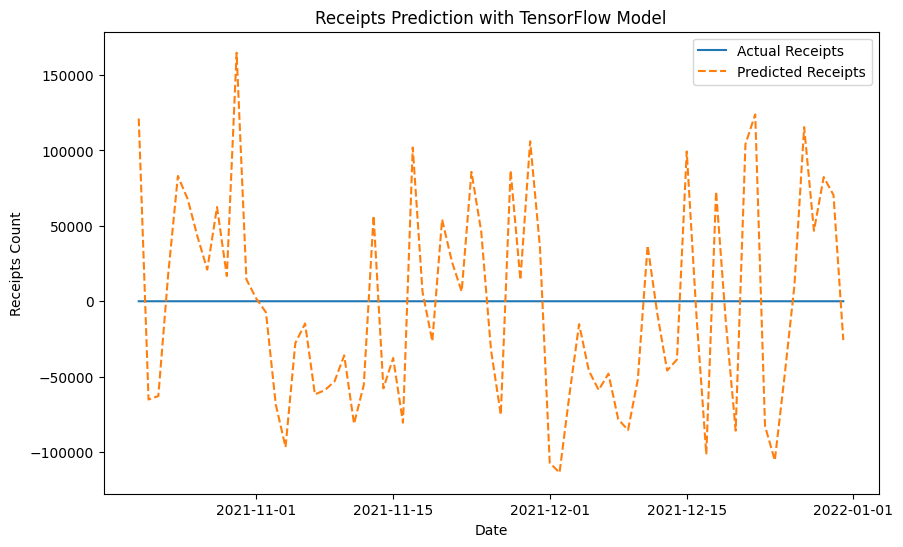

In [ ]:
# Visualization
plt.figure(figsize=(10, 6))
plt.plot(test_data['date'], y_test, label='Actual Receipts')
plt.plot(test_data['date'], predictions, label='Predicted Receipts', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Receipts Count')
plt.title('Receipts Prediction with TensorFlow Model')
plt.legend()
plt.show()

In [ ]:
# Prediction for another year (adjust dates accordingly)
future_dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
future_features = pd.DataFrame({
    'day_of_week': future_dates.dayofweek,
    'day_of_month': future_dates.day,
    'month': future_dates.month
})

In [ ]:
# Standardize features for future predictions
future_features = scaler.transform(future_features)

In [ ]:
# Make predictions for the future dates
future_predictions = model.predict(future_features).flatten()

12/12 [==============================] - 0s 2ms/step


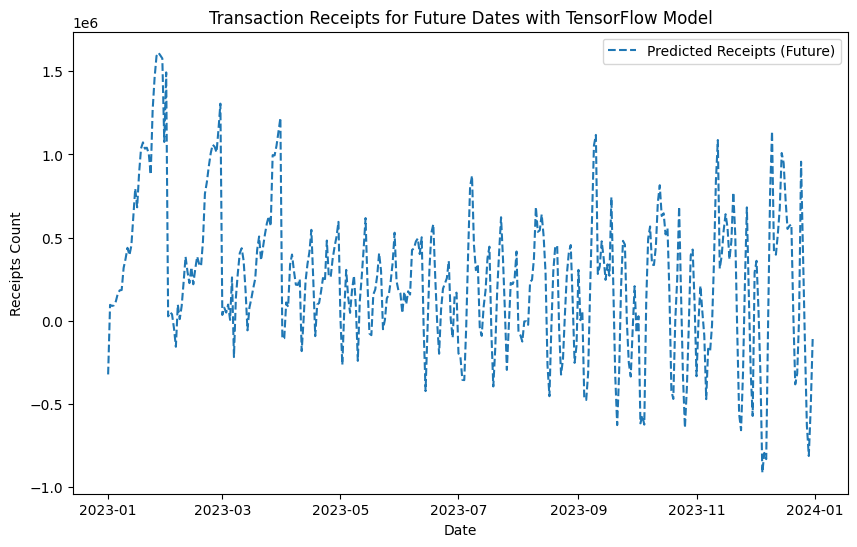

In [ ]:
# Visualization for future predictions
plt.figure(figsize=(10, 6))
plt.plot(future_dates, future_predictions, label='Predicted Receipts (Future)', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Receipts Count')
plt.title('Transaction Receipts for Future Dates with TensorFlow Model')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [ ]:
df.head()

,date,receipt_count,day_of_week,month,day_of_month
0,2021-01-01,0.756477,4,1,1
1,2021-01-02,0.745552,5,1,2
2,2021-01-03,0.709541,6,1,3
3,2021-01-04,0.766616,0,1,4
4,2021-01-05,0.777129,1,1,5


In [ ]:
df.columns

Index(['date', 'receipt_count', 'day_of_week', 'month', 'day_of_month'], dtype='object')

In [ ]:
# Features and target variable
features = ['day_of_week', 'month', 'day_of_month']
target = 'receipt_count'

In [ ]:
# Standardize features
scaler = StandardScaler()
train_data[features] = scaler.fit_transform(train_data[features])
test_data[features] = scaler.transform(test_data[features])

In [ ]:
# Training set
X_train = np.array(train_data[features])
y_train = np.array(train_data[target]) / 1e7

# Testing set
X_test = np.array(test_data[features])
y_test = np.array(test_data[target]) / 1e7

In [ ]:
X_train[:5]

array([[ 0.49680192, -1.56236325, -1.64244875],
       [ 0.99531106, -1.56236325, -1.52768564],
       [ 1.4938202 , -1.56236325, -1.41292253],
       [-1.49723464, -1.56236325, -1.29815942],
       [-0.9987255 , -1.56236325, -1.18339631]])

In [ ]:
y_train[:5]

array([0.7564766, 0.7455524, 0.7095414, 0.7666163, 0.7771289])

In [ ]:
X_train.shape

(292, 3)

In [ ]:
X_test.shape

(73, 3)

In [ ]:
# Reshape features for RNN input (samples, time steps, features)
# In this example, we use a time step of 1, but you can adjust it based on your needs
time_steps = 1
X_train = np.reshape(X_train, (X_train.shape[0], time_steps, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], time_steps, X_test.shape[1]))

In [ ]:
# Define and compile the RNN model
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2700      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2751 (10.75 KB)
Trainable params: 2751 (10.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
10/10 - 1s - loss: 0.6402 - 1s/epoch - 114ms/step
Epoch 2/50
10/10 - 0s - loss: 0.4285 - 40ms/epoch - 4ms/step
Epoch 3/50
10/10 - 0s - loss: 0.2746 - 39ms/epoch - 4ms/step
Epoch 4/50
10/10 - 0s - loss: 0.1744 - 44ms/epoch - 4ms/step
Epoch 5/50
10/10 - 0s - loss: 0.1136 - 41ms/epoch - 4ms/step
Epoch 6/50
10/10 - 0s - loss: 0.0802 - 42ms/epoch - 4ms/step
Epoch 7/50
10/10 - 0s - loss: 0.0628 - 41ms/epoch - 4ms/step
Epoch 8/50
10/10 - 0s - loss: 0.0518 - 38ms/epoch - 4ms/step
Epoch 9/50
10/10 - 0s - loss: 0.0448 - 37ms/epoch - 4ms/step
Epoch 10/50
10/10 - 0s - loss: 0.0400 - 40ms/epoch - 4ms/step
Epoch 11/50
10/10 - 0s - loss: 0.0358 - 38ms/epoch - 4ms/step
Epoch 12/50
10/10 - 0s - loss: 0.0322 - 37ms/epoch - 4ms/step
Epoch 13/50
10/10 - 0s - loss: 0.0294 - 36ms/epoch - 4ms/step
Epoch 14/50
10/10 - 0s - loss: 0.0269 - 47ms/epoch - 5ms/step
Epoch 15/50
10/10 - 0s - loss: 0.0249 - 36ms/epoch - 4ms/step
Epoch 16/50
10/10 - 0s - loss: 0.0234 - 36ms/epoch - 4ms/step
Epoch 17/50
10/10

In [ ]:
# Prediction for the testing set
predictions = model.predict(X_test).flatten()

3/3 [==============================] - 0s 6ms/step


In [ ]:
# Model evaluation
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 0.12067198973142022


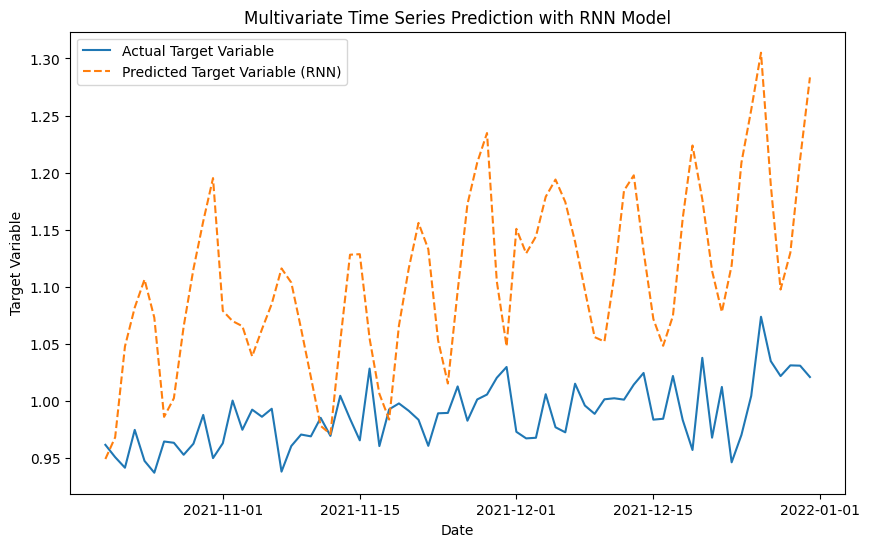

In [ ]:
# Visualization
plt.figure(figsize=(10, 6))
plt.plot(test_data['date'], y_test, label='Actual Target Variable')
plt.plot(test_data['date'], predictions, label='Predicted Target Variable (RNN)', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.title('Multivariate Time Series Prediction with RNN Model')
plt.legend()
plt.show()

In [ ]:
# Prediction for another year (adjust dates accordingly)
future_dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
future_features = np.array(future_dates.dayofweek).reshape(-1, time_steps, 1)  # Reshape for RNN input

# Make predictions for the future dates
future_predictions = model.predict(future_features).flatten()

# Visualization for future predictions
plt.figure(figsize=(10, 6))
plt.plot(future_dates, future_predictions, label='Predicted Target Variable (Future - RNN)', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.title('Multivariate Time Series Prediction for Future Dates with RNN Model')
plt.legend()
plt.show()


In [ ]:
pip install prophet

In [ ]:
df.head()

,date,receipt_count,day_of_week,month,day_of_month
0,2021-01-01,0.756477,4,1,1
1,2021-01-02,0.745552,5,1,2
2,2021-01-03,0.709541,6,1,3
3,2021-01-04,0.766616,0,1,4
4,2021-01-05,0.777129,1,1,5


In [ ]:
data = df[['date','receipt_count']]

In [ ]:
data = data.rename(columns={'date':'ds', 'receipt_count':'y'})

In [ ]:
data.head()

,ds,y
0,2021-01-01,0.756477
1,2021-01-02,0.745552
2,2021-01-03,0.709541
3,2021-01-04,0.766616
4,2021-01-05,0.777129


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgt1itgr6/6wdx6jjr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgt1itgr6/wwaqfiyq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56788', 'data', 'file=/tmp/tmpgt1itgr6/6wdx6jjr.json', 'init=/tmp/tmpgt1itgr6/wwaqfiyq.json', 'output', 'file=/tmp/tmpgt1itgr6/prophet_modeldq_2poa1/prophet_model-20231120201623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:16:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:16:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


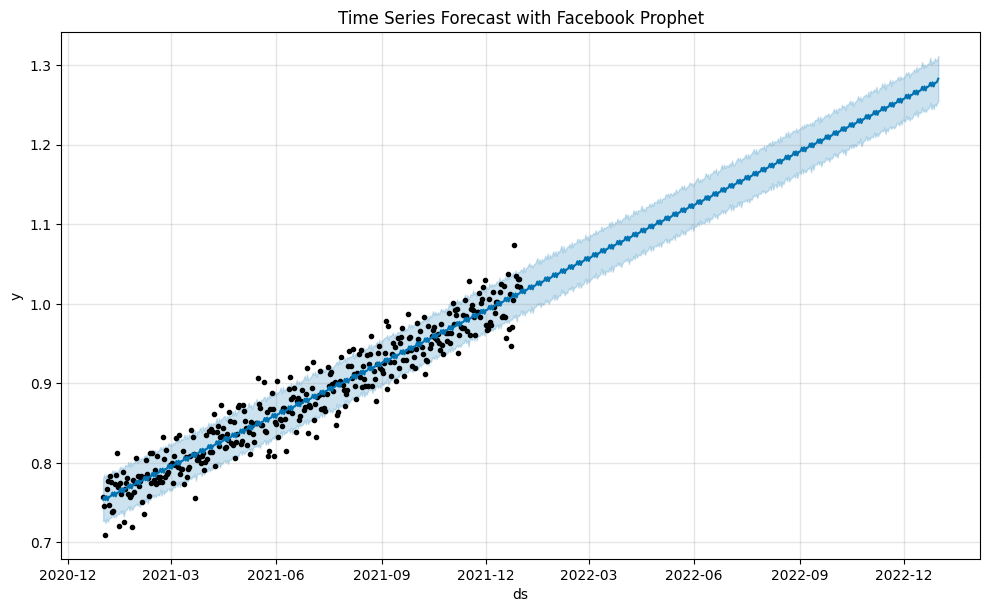

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load your time series data
# Assuming your data has a 'ds' column for dates and a 'y' column for the target variable
# Replace 'your_data.csv' with your actual file path
# data = pd.read_csv('data_daily.csv')
# data['ds'] = pd.to_datetime(data['ds'])

# Initialize the Prophet model
model = Prophet()

# Fit the model with your time series data
model.fit(data)

# Create a dataframe with future dates for prediction
future = model.make_future_dataframe(periods=365)  # Adjust the number of days as needed

# Make predictions for the future dates
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Time Series Forecast with Facebook Prophet')
plt.show()


INFO:prophet:Making 2 forecasts with cutoffs between 2021-06-04 00:00:00 and 2021-12-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpgt1itgr6/dk59n_c9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgt1itgr6/wq17b5rk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59439', 'data', 'file=/tmp/tmpgt1itgr6/dk59n_c9.json', 'init=/tmp/tmpgt1itgr6/wq17b5rk.json', 'output', 'file=/tmp/tmpgt1itgr6/prophet_model8sfwrha3/prophet_model-20231120201841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:18:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:18:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgt1itgr6/klrylks8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgt1itgr6/6tx_qtxc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

   horizon       mse      rmse       mae      mape     mdape     smape  \
0   3 days  0.000305  0.017452  0.013871  0.014772  0.011052  0.014614   
1   4 days  0.000229  0.015144  0.012566  0.013432  0.012861  0.013338   
2   5 days  0.000216  0.014709  0.012414  0.013251  0.013336  0.013164   
3   6 days  0.000809  0.028450  0.024014  0.026897  0.019481  0.026463   
4   7 days  0.000743  0.027263  0.020420  0.023067  0.017723  0.022644   
5   8 days  0.000756  0.027503  0.020671  0.023424  0.016789  0.023145   
6   9 days  0.000512  0.022629  0.015525  0.016980  0.008442  0.017267   
7  10 days  0.000519  0.022775  0.016073  0.017596  0.010506  0.017891   
8  11 days  0.000367  0.019151  0.009751  0.010714  0.001909  0.010941   
9  12 days  0.000049  0.006990  0.005545  0.005949  0.005452  0.005976   
10 13 days  0.000213  0.014600  0.011467  0.011988  0.011346  0.012104   
11 14 days  0.000471  0.021705  0.020144  0.021782  0.021452  0.021731   
12 15 days  0.000525  0.022917  0.0216

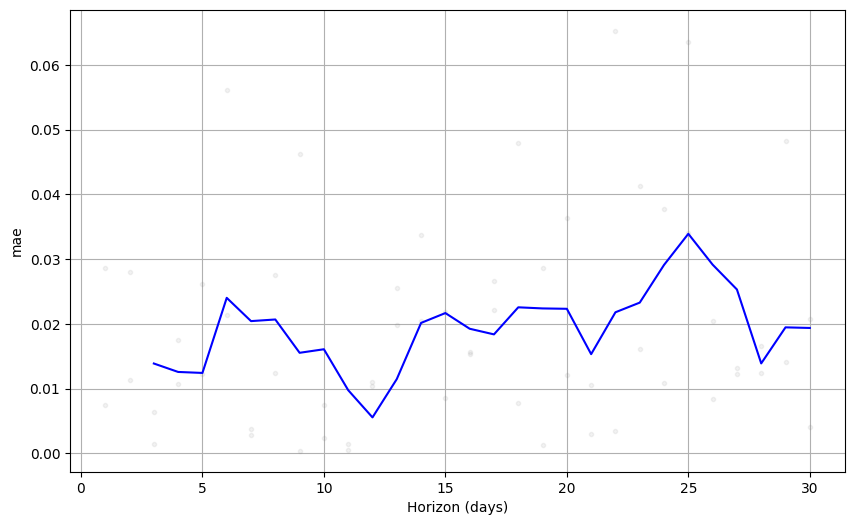

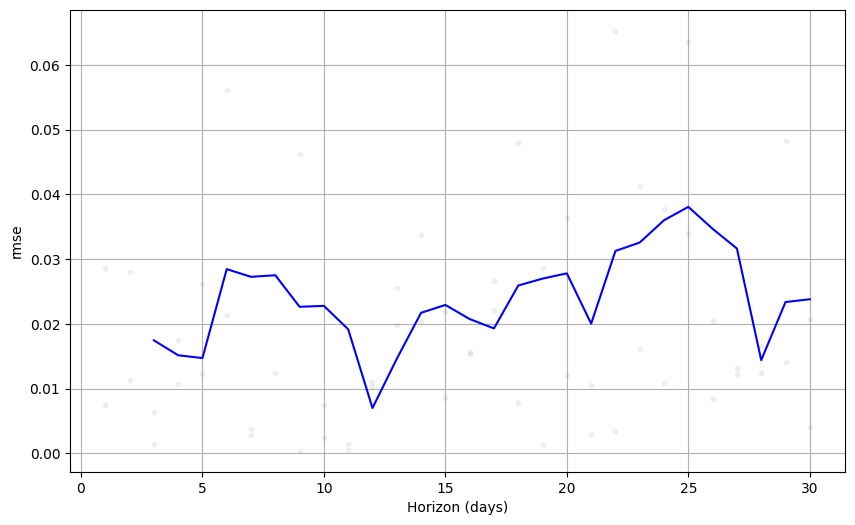

In [ ]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

# Perform cross-validation
df_cv = cross_validation(model, initial='30 days', period='180 days', horizon='30 days')

# Compute performance metrics
df_metrics = performance_metrics(df_cv)

# Print metrics
print(df_metrics)

# Plot MAE and RMSE
fig_mae = plot_cross_validation_metric(df_cv, metric='mae')
fig_rmse = plot_cross_validation_metric(df_cv, metric='rmse')

# Show the plots
plt.show()
